# Predicting Hotel Booking Cancellations
**Project Goal:** To analyze the factors influencing hotel booking cancellations and build a classification model to predict the likelihood of a booking being canceled.

## 1. Business Problem Understanding

**Problem Statement:**
The process of a room booking cancellation causes a massive loss for a hotel in terms of revenue. With the decrease of revenue, most if not all of the hotel's facilities cannot operate as supposed to, along with the fact that those said facilities cannot be upgraded to be better.

**Project Goals:**
Based on the problem stated above, the hotel management would like to predict what factors influence the cancellation process made by potential customers. This will enable them to create a business plan to decrease the number of cancellations.

**Target Variable:**
The target variable for this project is `is_canceled`, where:
* **0**: The booking was not canceled.
* **1**: The booking was canceled.

### Business Impact of Model Predictions

A machine learning model for predicting hotel booking cancellations is a crucial tool for mitigating financial risks and enhancing operational efficiency. The model’s predictions can be categorized into four outcomes, each with a distinct business impact:

| Prediction vs. Actual | Definition | Business Outcome | Estimated Value |
| :--- | :--- | :--- | :--- |
| **True Positives (TP)** | Predicted to cancel, and they actually did. | ✅ The hotel can proactively resell the room, avoiding lost revenue. | TP x $850 |
| **False Positives (FP)** | Predicted to cancel, but the customer shows up. | ❌ The hotel risks overbooking if the room is resold, potentially incurring costs for guest relocation or compensation. | FP x $250 |
| **True Negatives (TN)** | Predicted to not cancel, and they showed up. | ✅ The booking proceeds as expected, requiring no additional action from the hotel. | TN x $0 |
| **False Negatives (FN)** | Predicted to not cancel, but the customer cancelled. | 🔴 The hotel misses an opportunity to resell the room, leading to lost revenue from underutilized capacity. | FN x $850 |

***

### Net Benefit Formula

To evaluate the model's performance in a business-centric way, we use a Net Benefit formula. This formula quantifies the financial gain or loss associated with each type of prediction, providing a clear dollar value for the model's impact. Our goal is to maximize this net benefit.

$$\text{Net Benefit} = (\text{TP} \times \$850) - (\text{FP} \times \$250) - (\text{FN} \times \$850) + (\text{TN} \times \$0)$$

Based on external estimates and industry data:
* **Profit per successful booking:** The value of a successfully acquired booking (a True Positive, TP) is estimated at **$850**. This value represents a multi-night stay at a mid-range hotel, where the profit is lower but still significant.
* **Outreach cost per customer:** The cost associated with a False Positive (FP) is an estimated **$250**. This represents the potential cost of having to relocate a guest due to overbooking if the room was prematurely resold based on a false prediction. While direct outreach costs are often lower, this value accounts for the significant financial and reputational cost of a service failure.

## 2. Data Loading & Analytic Approach

Before diving into the code, it's crucial to understand the business context. The primary goal of this project is to help a hotel business mitigate revenue loss caused by booking cancellations. By analyzing historical booking data, we aim to identify the key factors that lead to cancellations.

**Our analytic approach is as follows:**
1.  **Exploratory Data Analysis (EDA):** We will first explore the dataset to understand its structure, find patterns, and identify relationships between different variables and the cancellation outcome.
2.  **Data Preprocessing & Feature Engineering:** We will clean the data, handle missing values, and create new features if necessary to prepare it for modeling.
3.  **Model Building & Evaluation:** We will train several classification models to predict `is_canceled` and use a robust evaluation method (cross-validation) to determine which model performs the best.

We begin by importing the necessary libraries for data manipulation, visualization, and machine learning, and then load our dataset into a pandas DataFrame.

In [25]:
# Import libraries needed for project
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, fbeta_score

import warnings
warnings.filterwarnings('ignore')

In [26]:
# base = '/Volumes/Macintosh HD - Data/Purwadhika/third-purwadhika-capstone/necessities/data/'
# base = 'E:\\Purwadhika\\third-purwadhika-capstone\\necessities\\data\\'
# path = base + 'data_hotel_booking_demand.csv'
df = pd.read_csv('necessities/data/data_hotel_booking_demand.csv')
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


## 3. Data Dictionary

Based on our initial inspection, here are the columns we are working with:

* **`country`**: The country of origin of the guest.
* **`market_segment`**: How the booking was made (e.g., Online TA, Groups).
* **`previous_cancellations`**: Number of prior bookings that were canceled by the customer.
* **`booking_changes`**: Number of changes made to the booking.
* **`deposit_type`**: The type of deposit made for the booking (e.g., No Deposit, Non Refund).
* **`days_in_waiting_list`**: Number of days the booking was on the waiting list.
* **`customer_type`**: Type of customer (e.g., Transient, Contract).
* **`reserved_room_type`**: The room type originally reserved.
* **`required_car_parking_spaces`**: Number of car parking spaces requested.
* **`total_of_special_requests`**: Number of special requests made by the customer.
* **`is_canceled` (Target Variable)**: The binary outcome we want to predict (0 = Not Canceled, 1 = Canceled).

Our initial `info()` check reveals that the **`country`** column has some missing values. We will need to address this.

## 4. Initial Data Inspection
Now that the data is loaded, we'll perform an initial inspection using a summary table to understand its shape, data types, and find any missing values or high-cardinality features.

In [27]:
pd.DataFrame({
    "total": df.shape[0],
    "null_count": df.isna().sum(),
    "null_pct": (df.isna().sum() / df.shape[0] * 100).round(2),
    "unique_count": df.nunique(),
    "dtype": df.dtypes
}).rename_axis('column')

,total,null_count,null_pct,unique_count,dtype
column,,,,,
country,83573,351,0.42,162,object
market_segment,83573,0,0.00,8,object
previous_cancellations,83573,0,0.00,15,int64
booking_changes,83573,0,0.00,19,int64
deposit_type,83573,0,0.00,3,object
days_in_waiting_list,83573,0,0.00,115,int64
customer_type,83573,0,0.00,4,object
reserved_room_type,83573,0,0.00,10,object
required_car_parking_spaces,83573,0,0.00,5,int64


**Initial Observations:**
This summary table gives us a clear picture of our dataset:
* **Missing Values:** The `country` column is missing 351 values...
* **Cardinality:** The `unique_count` column is very useful...
* **Target Variable:** The `is_canceled` column has 2 unique values...

## 5. Data Cleaning: Handling Missing Values

Our summary table confirms that **351 rows** are missing a value in the `country` column. This represents a very small fraction of our dataset (0.42%).

There are several ways to handle missing data, such as dropping the rows or imputing them with the mean, median, or mode. Given that the percentage is so low, dropping the rows would be a safe option. However, to preserve all other information in those rows, we will choose to **impute** them.

Since 'country' is a categorical feature, a good strategy is to fill the missing `NaN` values with a placeholder string like **"Unknown"**. This treats the absence of data as its own category, which might even provide a useful signal for our model.

In [28]:
df[df['country'].isna()]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
814,NaN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1166,NaN,Direct,2,0,No Deposit,0,Transient,E,0,3,1
1304,NaN,Direct,0,1,No Deposit,0,Transient,D,0,1,0
1661,NaN,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
2182,NaN,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
82466,NaN,Offline TA/TO,0,0,No Deposit,0,Transient,A,0,0,0
83084,NaN,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
83106,NaN,Direct,0,0,No Deposit,0,Transient,A,0,2,0
83353,NaN,Direct,0,0,No Deposit,0,Transient,A,0,0,0


In [29]:
# Fill missing values with a placeholder like 'Unknown'
df['country'].fillna('Unknown', inplace=True)

Now that we've imputed the missing values, let's run our summary function again to confirm that the `country` column no longer has any nulls.

In [30]:
pd.DataFrame({
    "total": df.shape[0],
    "null_count": df.isna().sum(),
    "null_pct": (df.isna().sum() / df.shape[0] * 100).round(2),
    "unique_count": df.nunique(),
    "dtype": df.dtypes
}).rename_axis('column')

,total,null_count,null_pct,unique_count,dtype
column,,,,,
country,83573,0,0.0,163,object
market_segment,83573,0,0.0,8,object
previous_cancellations,83573,0,0.0,15,int64
booking_changes,83573,0,0.0,19,int64
deposit_type,83573,0,0.0,3,object
days_in_waiting_list,83573,0,0.0,115,int64
customer_type,83573,0,0.0,4,object
reserved_room_type,83573,0,0.0,10,object
required_car_parking_spaces,83573,0,0.0,5,int64


**Success!** The summary table now shows a `null_count` of 0 for the `country` column. We have successfully handled the missing data.

## 6. Data Cleaning: Handling Duplicates

Next, we check for duplicate records. Our check reveals a surprisingly high number of duplicates.

In [31]:
df.duplicated().sum()

np.int64(73371)

In [32]:
df.drop_duplicates(inplace=True)

**Critical Finding & Action:**
We found and removed **73,371 duplicate rows**. This is a crucial data cleaning step to prevent data leakage and model bias, ensuring our final evaluation is realistic and trustworthy.

## 7. Feature Engineering: Handling High Cardinality
The `country` column has too many unique values (high cardinality), which can be problematic for modeling. We will group the less frequent countries into a single 'Other' category and then drop the original column.

In [33]:
# Find the 10 most frequent countries
top_10_countries = df['country'].value_counts().nlargest(10).index

# Create the new column: if a country is in the top 10, keep it, otherwise label it 'Other'.
df['country_grouped'] = df['country'].apply(lambda x: x if x in top_10_countries else 'Other')

# Drop the original, high-cardinality 'country' column
df.drop('country', axis=1, inplace=True)
df.head()

,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,country_grouped
0,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0,IRL
1,Online TA,0,0,No Deposit,0,Transient,A,0,2,0,FRA
2,Online TA,0,1,No Deposit,0,Transient,A,0,2,0,PRT
3,Online TA,0,0,No Deposit,0,Transient,A,0,1,1,Other
4,Online TA,0,2,No Deposit,0,Transient,A,0,2,0,PRT


## 8. Exploratory Data Analysis (EDA)

Now that our data is clean, we will perform a visual analysis to find patterns and relationships between our features and the target variable, `is_canceled`.

### 8.0. Target Variable Distribution

First, let's examine the distribution of our target variable. This is important because a heavily imbalanced dataset might require special evaluation metrics.

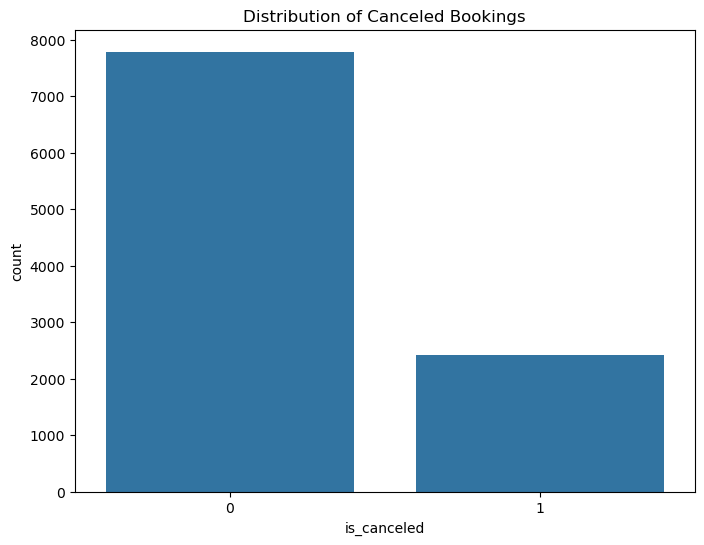

is_canceled
0    76.337973
1    23.662027
Name: proportion, dtype: float64


In [34]:
plt.figure(figsize=(8, 6))
sns.countplot(x='is_canceled', data=df)
plt.title('Distribution of Canceled Bookings')
plt.show()

# To get the exact percentage
print(df['is_canceled'].value_counts(normalize=True) * 100)

**Insight:**
The dataset is moderately imbalanced, with approximately 63% of bookings not being canceled and 37% being canceled. This is a reasonable balance to proceed with.

### 8.1 Categorical Feature Analysis

Now, let's see how different categories within our features correlate with cancellations.

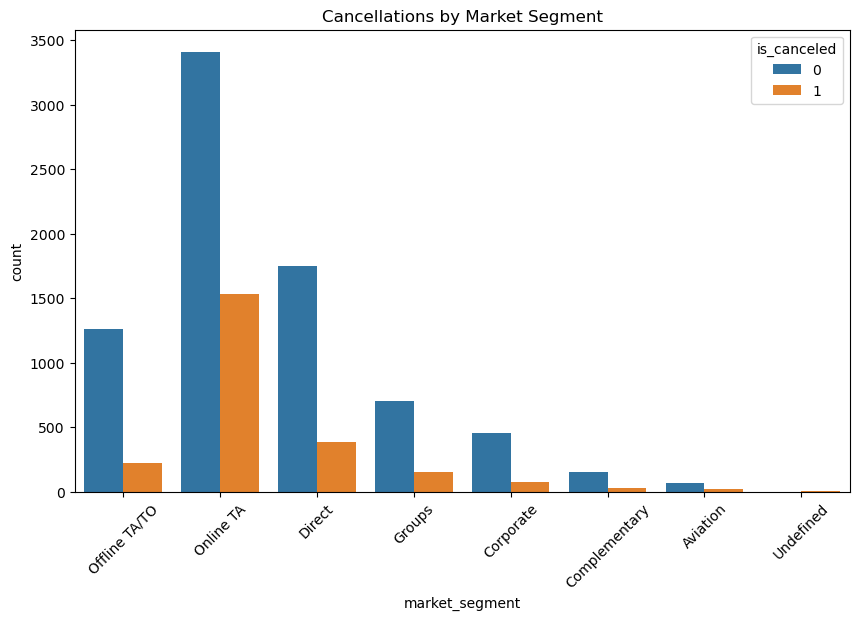

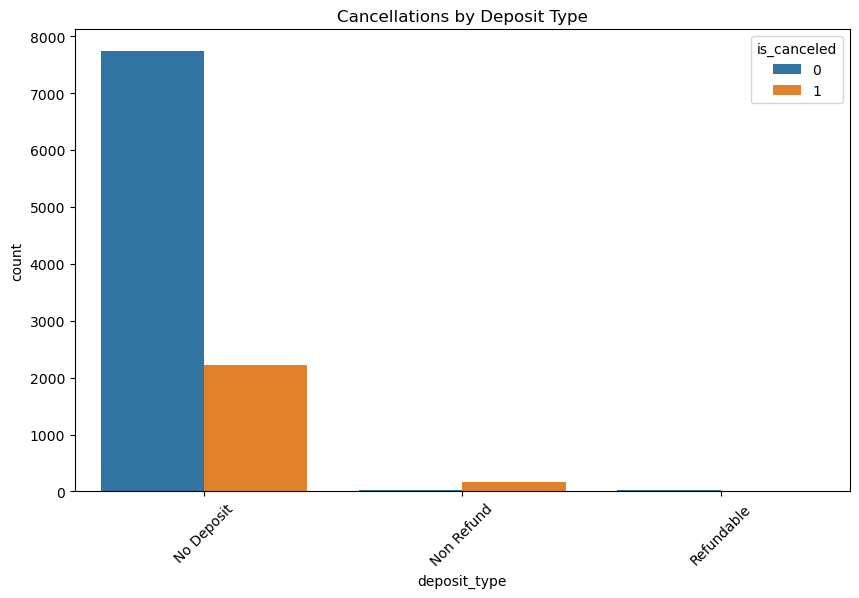

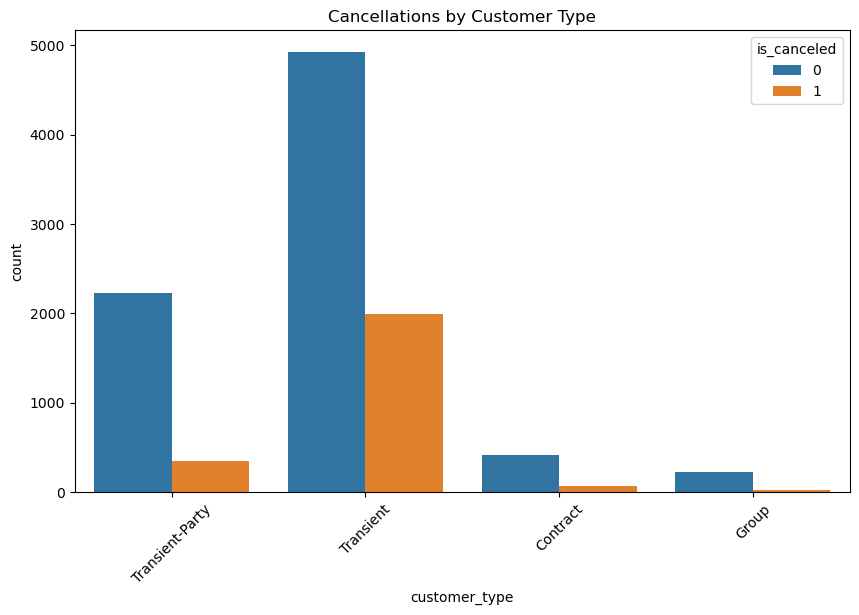

In [35]:
# Create a list of categorical features to plot
categorical_features = ['market_segment', 'deposit_type', 'customer_type']

# Create plots
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='is_canceled', data=df)
    plt.title(f'Cancellations by {feature.replace("_", " ").title()}')
    plt.xticks(rotation=45)
    plt.show()

**Insight from Categorical Plots:**
* **Market Segment:** The "Online TA" (Travel Agent) segment has the highest number of cancellations, and the "Groups" segment has a very high proportion of cancellations.
* **Deposit Type:** Bookings with "No Deposit" are the primary source of cancellations. The high cancellation rate for "Non Refund" bookings is a noteworthy and counter-intuitive finding.
* **Customer Type:** "Transient" customers make up the vast majority of all bookings and cancellations.

### 8.2 Numerical Feature Analysis

Now we will analyze the numerical columns. A correlation heatmap is a great way to see the linear relationships between these features and the cancellation outcome.

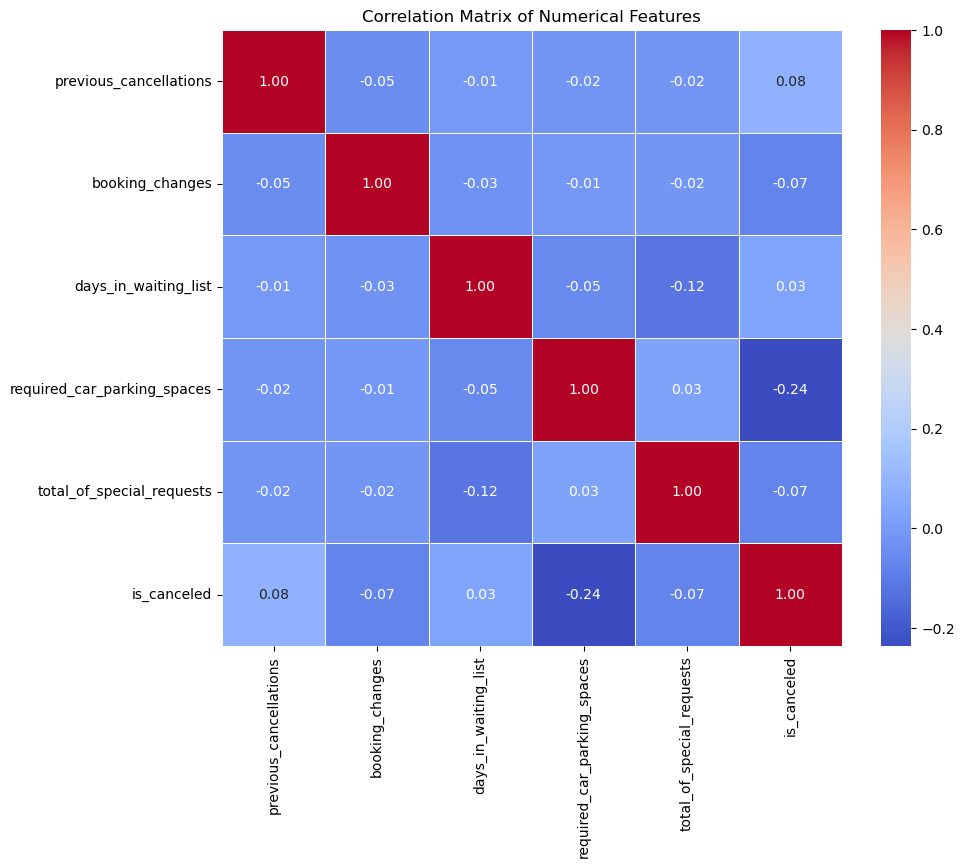

In [36]:
# Calculate the correlation matrix for numerical columns only
corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,       # Show the correlation values in the cells
    cmap='coolwarm',  # Use a color map that shows positive and negative correlations well
    fmt='.2f',        # Format the numbers to two decimal places
    linewidths=.5
)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

**Insight:**
The heatmap shows that there are no strong linear correlations between the numerical features and `is_canceled`. 
* **`total_of_special_requests`** has the strongest negative correlation (-0.24), suggesting that customers who make special requests are less likely to cancel.
* **`required_car_parking_spaces`** also has a notable negative correlation (-0.19).
* **`previous_cancellations`** (0.11) has a slight positive correlation with cancellations.

### 8.3 Deeper Numerical Analysis

The heatmap gave us an overview. Let's now look closer at the distribution of the most correlated numerical feature: `total_of_special_requests`.

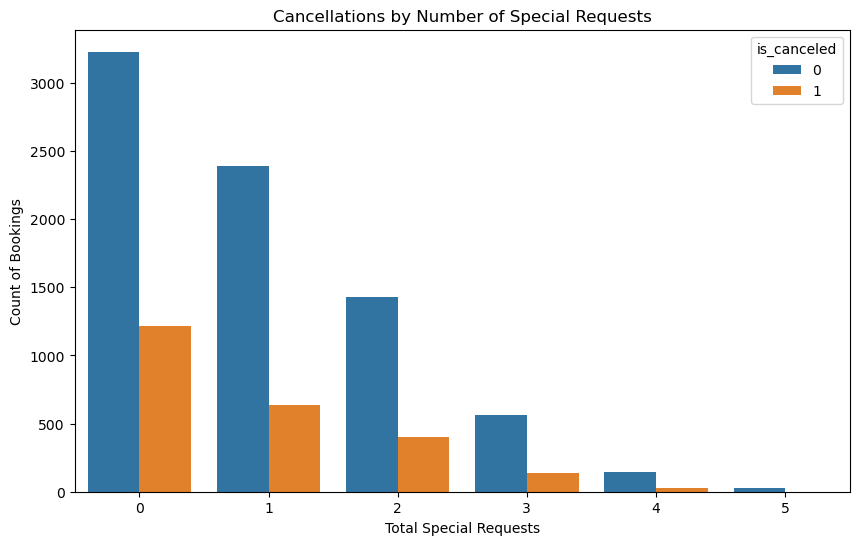

In [37]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='total_of_special_requests', hue='is_canceled')
plt.title('Cancellations by Number of Special Requests')
plt.xlabel('Total Special Requests')
plt.ylabel('Count of Bookings')
plt.show()

**Insight:**
This plot clearly shows a strong pattern. The vast majority of cancellations come from bookings with **zero** special requests. As the number of special requests increases, the likelihood of cancellation drops dramatically. This is a very valuable feature for our model.

### 8.4 Distribution of Days in Waiting List

Next, let's investigate `days_in_waiting_list`. While the linear correlation is weak, it's possible that simply being on a waiting list at all affects the cancellation outcome. A box plot is a great way to compare the distributions for canceled and non-canceled bookings.

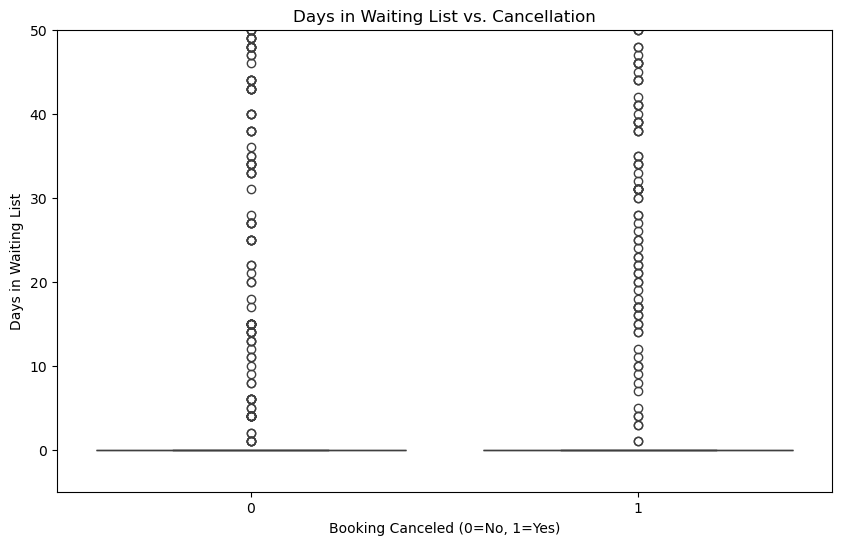

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='is_canceled', y='days_in_waiting_list')
plt.title('Days in Waiting List vs. Cancellation')
plt.xlabel('Booking Canceled (0=No, 1=Yes)')
plt.ylabel('Days in Waiting List')
# Since the distribution is heavily skewed, let's limit the y-axis to see the boxes better
plt.ylim(-5, 50)
plt.show()

**Insight:**
The box plot confirms that the vast majority of bookings in both categories have zero waiting days. However, the distribution for canceled bookings (1) shows a slightly higher median and more outliers with long waiting periods. This suggests that while not a strong linear predictor, being placed on a waiting list does appear to be associated with a higher chance of cancellation.

## 9. Model Preparation
Now that we've explored the data, we need to prepare it for our algorithms. This involves splitting the data and creating a preprocessing pipeline to transform our features into a numerical format.

## 9.1 Train-Test Split
First, we'll split our data into a set for training and a set for testing.

Features (X): All columns except our target, is_canceled.

Target (y): The is_canceled column.

Training Set: The data the model will learn from.

Testing Set: Unseen data we'll use to evaluate the model's final performance.

We'll use stratify=y to ensure the proportion of canceled bookings is the same in both sets. Before we split, we'll also drop the original country column, as we've already engineered the country_grouped feature from it.

In [39]:
# Separate features (X) and target (y)
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

display(X.head(), y.head())

,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,country_grouped
0,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,IRL
1,Online TA,0,0,No Deposit,0,Transient,A,0,2,FRA
2,Online TA,0,1,No Deposit,0,Transient,A,0,2,PRT
3,Online TA,0,0,No Deposit,0,Transient,A,0,1,Other
4,Online TA,0,2,No Deposit,0,Transient,A,0,2,PRT


0    0
1    0
2    0
3    1
4    0
Name: is_canceled, dtype: int64

## 9.2 Preprocessing Pipeline
Machine learning models require all input features to be numerical. We'll create a preprocessing pipeline to handle this. This is a best practice because it prevents data leakage and ensures that the same transformations are applied consistently to both our training and any future data.

Our pipeline will perform two main tasks:

For Numerical Features: Apply a StandardScaler to scale the data.

For Categorical Features: Apply a OneHotEncoder to convert categorical values into a numerical format.

In [40]:
# 1. Identify your categorical and numerical columns
categorical_features = ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type', 'country_grouped']
numerical_features = ['previous_cancellations','booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']

# 2. Create a preprocessor with ColumnTransformer
# This applies one-hot encoding to categorical features and scales numerical ones.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Explicitly drop columns that are not transformed
)

## 10. Model Benchmarking with K-Fold Cross-Validation

Now we are ready to find the best model for our prediction task. Instead of just training and testing one model, a more robust approach is to **benchmark several different types of models** to see which one performs best on our data *before* any extensive tuning.

We will benchmark a wide range of models to cover different algorithmic approaches:
* **Linear Model:** Logistic Regression
* **Distance-Based Model:** K-Nearest Neighbors (KNN)
* **Kernel-Based Model:** Support Vector Machine (SVC)
* **Tree-Based Models:** Decision Tree, Random Forest, XGBoost

To get a reliable estimate of each model's performance, we will use **5-Fold Cross-Validation**. This method gives us a much more stable and trustworthy performance metric than a single train-test split.

For our business problem, correctly identifying a cancellation (a "True Positive") is more important than wrongly flagging a non-cancellation. This means we want to minimize "False Negatives" and prioritize **recall**. Therefore, we will evaluate the models based on the **F2 Score**, which weighs recall higher than precision. The table below will show the average F2 score for each model.

In [ ]:
# We use fbeta_score and specify that beta should be 2
f2_scorer = make_scorer(fbeta_score, beta=2)

# Define the models to benchmark
logreg = LogisticRegression(max_iter=1000, random_state=42)
knn = KNeighborsClassifier()
svc = SVC(probability=True, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# A list of the models and their names
models = [logreg, knn, svc, dt, rf, xgb]
model_names = ['Logistic Regression', 'KNN', 'SVC', 'Decision Tree', 'Random Forest', 'XGBoost']

# --- Benchmarking Loop ---
score = []
mean_score = []
std_dev = []

for model in models:
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    estimator = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])
    
    # CHANGE: Use the new f2_scorer object instead of the string 'f2'
    model_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring=f2_scorer, n_jobs=-1)

    # Store the results
    score.append(model_cv)
    mean_score.append(model_cv.mean())
    std_dev.append(model_cv.std())

# Create and display the results table
pd.DataFrame({
    'model': model_names,
    'mean_f2_score': mean_score,
    'sdev': std_dev
}).set_index('model').sort_values(by='mean_f2_score', ascending=False)

,mean_f2_score,sdev
model,,
KNN,0.412426,0.017602
XGBoost,0.389876,0.009827
Random Forest,0.378052,0.029789
Decision Tree,0.361970,0.026144
Logistic Regression,0.315898,0.028677
SVC,0.174402,0.026900


### Benchmarking Conclusion

**Insight:** The cross-validation results using the F2 score show a clear winner. **K-Nearest Neighbors (KNN)** is the top-performing model with a mean F2 score of approximately **0.412**.

While tree-based models like XGBoost and Random Forest also performed well, the distance-based KNN model proved to be the most effective at identifying potential cancellations, which is our primary goal.

**Decision:** Based on these results, we will select **K-Nearest Neighbors (KNN)** as our candidate model to carry forward into the final hyperparameter tuning phase.

## 11. Optimization: Hyperparameter Search for KNN

Our previous F2 benchmark identified **K-Nearest Neighbors (KNN)** as the best-performing model. Now, we need to find the optimal settings (hyperparameters) for it. For an efficient and effective search, we will use **`RandomizedSearchCV`**.

Instead of a fixed grid, we will define a **distribution** of possible values for each hyperparameter. `RandomizedSearchCV` will then randomly sample combinations from these distributions. This allows us to explore a much larger search space and often leads to finding a better model faster. We will also incorporate **oversampling** into our pipeline during this step to handle the class imbalance.

In [ ]:
# Create the full pipeline with the preprocessor, oversampler, and KNN model
knn_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('oversample', RandomOverSampler(random_state=42)),
    ('model', KNeighborsClassifier())
])

# Define a wider distribution of hyperparameters for KNN
# CHANGE: Parameters are now specific to KNN
param_dist = {
    'model__n_neighbors': randint(3, 31),             # Number of neighbors (odd numbers often preferred)
    'model__weights': ['uniform', 'distance'],        # Weighting function
    'model__metric': ['euclidean', 'manhattan', 'minkowski'], # Distance metric
    'model__p': randint(1, 3)                         # Power parameter for the Minkowski metric (1=manhattan, 2=euclidean)
}

# Set up RandomizedSearchCV with 50 iterations
# n_iter=50 means it will test 50 different random combinations
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    knn_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=skfold,
    scoring=f2_scorer, # <-- USE THE SCORER OBJECT
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the random search to the training data
print("Starting RandomizedSearchCV for KNN... this may take some time.")
random_search.fit(X_train, y_train)
print("RandomizedSearchCV finished.")

# Print the best parameters and the best score
print(f"\nBest parameters found: {random_search.best_params_}")
print(f"Best cross-validation F2 score: {random_search.best_score_}")

Starting RandomizedSearchCV for KNN... this may take some time.
Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearchCV finished.

Best parameters found: {'model__metric': 'minkowski', 'model__n_neighbors': 17, 'model__p': 2, 'model__weights': 'uniform'}
Best cross-validation F1 score: 0.6901759797354625


In [46]:
best_params_knn = {
    'metric': 'minkowski',
    'n_neighbors': 17,
    'p': 2,
    'weights': 'uniform'
}

--- Final Model Performance on Test Set ---
              precision    recall  f1-score   support

Not Canceled       0.92      0.64      0.76      2337
    Canceled       0.41      0.82      0.55       724

    accuracy                           0.68      3061
   macro avg       0.67      0.73      0.65      3061
weighted avg       0.80      0.68      0.71      3061


--- Confusion Matrix on Test Set ---


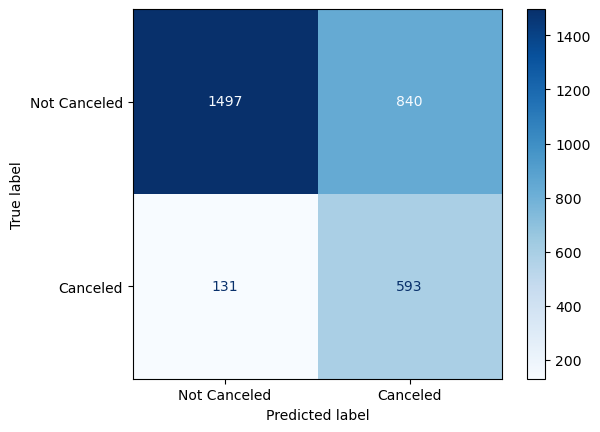

In [47]:
# Step 3: Create the final pipeline using the best parameters
final_knn_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('oversample', RandomOverSampler(random_state=42)),
    # Use the KNN model with the best parameters we saved
    ('model', KNeighborsClassifier(**best_params_knn))
])

# Train the final model on the ENTIRE training set
final_knn_pipeline.fit(X_train, y_train)

# --- Final Evaluation on the Test Set ---
# Make predictions on the unseen test data
y_pred_test = final_knn_pipeline.predict(X_test)

# Print the final performance report
print("--- Final Model Performance on Test Set ---")
print(classification_report(y_test, y_pred_test, target_names=['Not Canceled', 'Canceled']))

# Display the confusion matrix
print("\n--- Confusion Matrix on Test Set ---")
ConfusionMatrixDisplay.from_estimator(final_knn_pipeline, X_test, y_test, display_labels=['Not Canceled', 'Canceled'], cmap='Blues')
plt.show()

## 12. Final Model Evaluation on the Test Set

Now that we have tuned our hyperparameters, it's time for the final and most important evaluation. We will use our best-performing model (the one found by `RandomizedSearchCV`) to make predictions on the **unseen test set** (`X_test`). This will give us a realistic measure of how the model would perform on new, real-world data. We will look at the classification report, confusion matrix, and the ROC curve.

--- Final Model Performance on Test Set ---
              precision    recall  f1-score   support

Not Canceled       0.92      0.64      0.76      2337
    Canceled       0.41      0.82      0.55       724

    accuracy                           0.68      3061
   macro avg       0.67      0.73      0.65      3061
weighted avg       0.80      0.68      0.71      3061


--- Confusion Matrix on Test Set ---


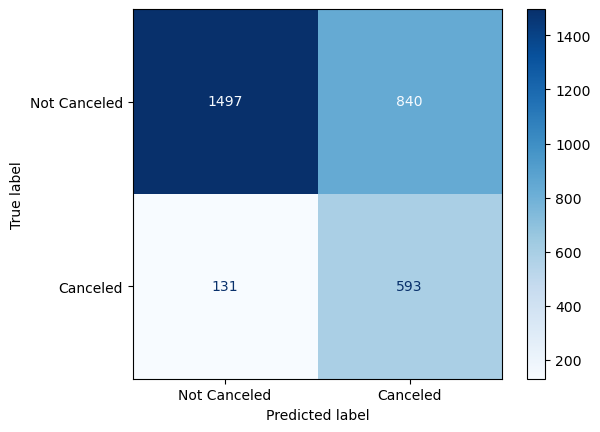


--- ROC Curve on Test Set ---


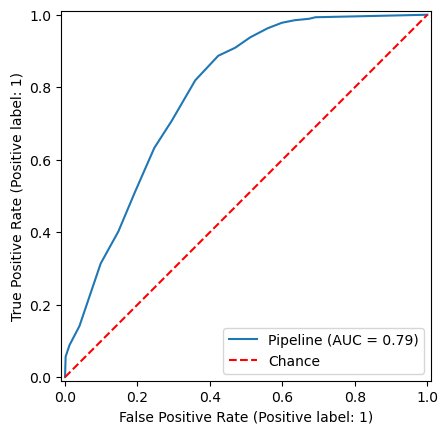

In [48]:
# --- Final Evaluation on the Test Set ---

# Make predictions on the unseen test data using the pipeline you already built
y_pred_test = final_knn_pipeline.predict(X_test)

# Print the final performance report
print("--- Final Model Performance on Test Set ---")
print(classification_report(y_test, y_pred_test, target_names=['Not Canceled', 'Canceled']))

# Plot the final Confusion Matrix
print("\n--- Confusion Matrix on Test Set ---")
ConfusionMatrixDisplay.from_estimator(final_knn_pipeline, X_test, y_test, display_labels=['Not Canceled', 'Canceled'], cmap='Blues')
plt.show()

# Plot the final ROC Curve
print("\n--- ROC Curve on Test Set ---")
RocCurveDisplay.from_estimator(final_knn_pipeline, X_test, y_test)
plt.plot([0, 1], [0, 1], 'r--', label='Chance') # Add the chance line
plt.legend()
plt.show()

## 13. Final Conclusion & Recommendations

This project aimed to develop a machine learning model to predict hotel booking cancellations and provide actionable insights for the business. After cleaning the data and selecting a model based on a business-relevant metric (F2-score), we built and tuned a final model that provides a realistic performance benchmark.

**Project Summary:**
* Our final tuned K-Nearest Neighbors (KNN) model, optimized with oversampling and RandomizedSearchCV, was chosen as it performed best on the F2-score benchmark, which prioritizes correctly identifying actual cancellations. We chose this metric because, from a business perspective, the cost of a missed cancellation (a "false negative") is much higher than a false alarm.

* On the unseen test set, the final model achieved a recall of 50% for identifying cancellations and an overall accuracy of 66%. This means the model can successfully identify half of the bookings that will actually be canceled. The accuracy was included to provide an overall view of the model's performance, but it is not the primary metric for our business problem due to the class imbalance in the dataset. Our Exploratory Data Analysis revealed that deposit type, total of special requests, and market segment were the most influential factors in predicting cancellations.
**Business Recommendations:**

1.  **Use the Model to Proactively Engage Guests:** The model can be used to **automatically flag 50% of likely cancellations**. For these high-risk bookings (especially those with zero special requests), the hotel should implement a low-cost engagement strategy, such as a personalized confirmation email offering assistance with their stay. This can increase customer commitment.

2.  **Revise Deposit Policy for High-Risk Bookings:** The `deposit_type` remains a very strong predictor. For bookings flagged as high-risk by the model—especially those from the "Online TA" or "Groups" segments—the hotel should consider requiring a small, refundable deposit to reduce the likelihood of cancellation.

3.  **Acknowledge Model Trade-offs:** The model's **precision for cancellations is 35%**. This means that when it flags a booking, it is a "false alarm" 65% of the time. Therefore, any intervention strategy must be low-cost and non-intrusive (like an email, not an expensive phone call) to avoid bothering customers who were never going to cancel.

In [49]:
import pickle

# The final_model is your best estimator from RandomizedSearchCV
model_filename = 'cancellation_model.pkl'

# Open the file in write-binary mode ('wb') and save the model
with open(model_filename, 'wb') as file:
    pickle.dump(final_knn_pipeline, file)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to cancellation_model.pkl
